In [1]:
using DiffusionMLE, Plots, PyCall, CSV, DataFrames, HDF5

# Introduction

This is a minimal example on how to apply our maximum likelihood estimator to a set of homogeneous single-particle tracking data.  Here, "homogeneous" refers to the fact that the underlying diffusive dynamics is the same for all trajectories.  

For more details on the theoretical framework, please refer to the associated preprint:
> J. T. Bullerjahn and G. Hummer, "Maximum likelihood estimates of diffusion coefficients from single-molecule tracking experiments", https://arxiv.org/abs/2011.09955

# Generate trajectories

Each trajectory can be seen as a $d$-dimensional array (<code>Array{Float64,2}</code>), so the data set should be of the type <code>Array{Array{Float64,2},1}</code>.  

Here, we generate mock data, made up of $M$ $d$-dimensional trajectories of different lengths $N = \{N_{1}, N_{2}, \dots, N_{M}\}$.  The $N_{i}$ are distributed uniformly on the interval $[3,100]$.  

In [3]:
include("smeared_trajectory_integrator.jl")

const M = 2 # Number of trajectories
const d = 2 # Dimension of trajectories

const N_sub = 100 # Number of substeps over which the trajectory is smeared out

N = [ rand(3:5) for i = 1 : M ] # Array of trajectory lengths

const a2 = 1.2
const σ2 = 2.3

B = [1/6 for m = 1 : M] # Array of blurring coefficients, where we have assumed a uniform illumination profile
data = make_2D_data(N,N_sub,a2,σ2); # Mock data set

In [4]:
# Import some test trajectories...
tester = raw"C:\Users\User\OneDrive\Documents\Python Programs\Piezo1_MLE\Trajectory_CSVs\tdTomato_Mobile\tdTomato_37Degree_mobile.csv"
test_data = CSV.read(tester, DataFrame);
trackIDs = unique(test_data, :ID).ID;

In [5]:
function load_traj_csv(raw_csv_file_path)
    csv_data = CSV.read(raw_csv_file_path, DataFrame)
    csv_data = dropmissing(csv_data)
    trackIDs = unique(csv_data, :ID).ID
    trackIDs = trackIDs[:][1:5]
    print(typeof(trackIDs))
    print(trackIDs)
    trk_count = length(trackIDs)
    B_values = [1/6 for m = 1 : trk_count]
    sing_cond_tracks = Array{Array{Float64,2},1}(undef, trk_count)
    n = 0
    for i in trackIDs
        n += 1
        indiv_track = csv_data[in([i]).(csv_data.ID), :]
        sing_cond_tracks[n] = Array(indiv_track[:, [:X, :Y]])
    end
    return sing_cond_tracks, B_values
end

load_traj_csv (generic function with 1 method)

In [6]:
try1, B_values = load_traj_csv(tester);

Vector{Int64}[0, 1, 2, 3, 4]

In [7]:
data

2-element Vector{Matrix{Float64}}:
 [-1.1150281936851032 -0.734999381632344; -0.7711616395630003 0.20110778122707745; -0.2473637886480511 -0.8990828810159519; -0.16298798466671374 -1.706455695957722]
 [1.2822251818731956 1.341274251394197; 0.31612237127065995 1.5416126393630158; 2.758805341731489 3.158135101923898; 3.7855155961169027 3.2478520781732407]

In [8]:
try1

5-element Vector{Matrix{Float64}}:
 [38.03921533198764 91.0106436419909; 38.09617753579804 91.00776183247646; … ; 38.66832991678541 91.03632763906067; 38.671069731886114 91.02072798480471]
 [52.30472173254977 93.76520392993226; 52.27783483328655 93.77576881939284; … ; 52.80411617421224 92.2611833862967; 52.8178544305479 92.20082214711363]
 [58.18545736344977 26.658555290703173; 58.16101127467751 26.60920696440354; … ; 57.71826713595652 25.462453963997746; 57.59620326290387 25.574767335748398]
 [68.02567255279081 55.05453029482074; 68.00926060531117 55.06106059930411; … ; 68.5030866291064 54.31561589602916; 68.5704694825362 54.32097210396887]
 [76.20040871000602 65.1557582450138; 76.15665586216313 65.15185150840257; … ; 76.06187844431993 66.0975418640479; 76.199015022925 66.09986918012656]

# Analyzing the data

### Parameter estimation

In [9]:
parameters = MLE_estimator(B_values,try1)
uncertainties = MLE_errors(B_values,try1,parameters)

println("Estimates:")
println(string("a2 = ", parameters[1], " ± ", uncertainties[1]))
println(string("σ2 = ",parameters[2], " ± ", uncertainties[2]))

println()

# println("Ground truth:")
# println(string("a2 = ", a2))
# println(string("σ2 = ", σ2))

Estimates:
a2 = 0.0025581823695079563 ± 0.0001487511625415108
σ2 = 0.0037964875708435004 ± 0.00019122018898654685



### Diffusion coefficients

Diffusion coefficients can be extracted from the $\sigma^2$-values, irrespective of the dimension $d$, as follows:
$\begin{equation*}
D = \frac{\sigma^2}{2 \Delta t} \, .  
\end{equation*}$
Here, $\sigma$ has the same dimension as the data, i.e., if the trajectories are recorded on the nanometer scale then $[\sigma] = \textrm{nm}$, and $\Delta t$ denotes the time step between two observations.  

# Testing model assumptions

We have assumed that the data are homogeneous.  To test this and other assumptions of our diffusion model (Gaussianity, structure of covariance matrix, etc.), we perform a quality factor analysis:

Kuiper statistic:
κ = 1.755304833117939


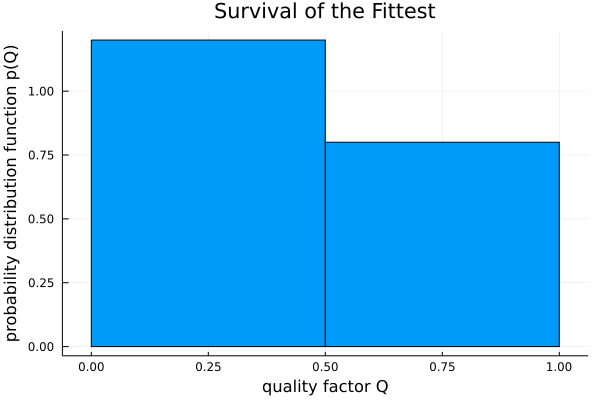


(process:18960): GLib-GIO-WARNING **: 12:39:17.249: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.1900.3.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


In [10]:
Q = Q_factor_analysis(B_values,try1,parameters)

println("Kuiper statistic:")
println(string("κ = ", Kuiper_statistic!(Q)))

Plots.histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q",
    ylabel="probability distribution function p(Q)",
    title="Survival of the Fittest")

The uniform distribution of the quality factors, as well as the fact that the Kuiper statistic evaluates close to unity, indicate that the assumptions underlying the model are satisfied.  This is, of course, not very surprising, because the mock data was generated with said assumptions in mind.  